In [2]:
from astropy.coordinates import SkyCoord, get_sun,FK4,get_body, EarthLocation, angular_separation
from astropy.time import Time

from datetime import timedelta
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import splrep,BSpline

from tqdm.notebook import tqdm

In [3]:
def bandToFreq(band):
    # Convert the input to a numpy array (if it's not already)
    band = np.asarray(band)
    
    # Create a mapping of band numbers to frequency values
    band_to_freq = {
        1: 0.45, 2: 0.70, 3: 0.90, 4: 1.31,
        5: 2.20, 6: 3.93, 7: 4.70, 8: 6.55, 9: 9.18
    }

    # Use np.vectorize to apply the mapping to each element in the array
    freq = np.vectorize(lambda b: band_to_freq.get(b, -1))(band)
    
    return freq

In [4]:
def raeAngFromSource(locations, source):
    position_x = np.array(locations['position_x'], dtype=float)
    position_y = np.array(locations['position_y'], dtype=float)
    position_z = np.array(locations['position_z'], dtype=float)
    
    ra,dec = cartToSphere(position_x,position_y,position_z)
    
    
    #ra = (long + 180) % 360 * u.deg
    #dec = -lat * u.deg
    ra = ra*u.deg
    dec = dec*u.deg
    
    raeCoord = SkyCoord(ra, dec, frame='icrs')
    sourceCoord = SkyCoord(ra=source[0], dec=source[1], frame='icrs',unit=(u.hourangle, u.deg))

    ang_sep = raeCoord.separation(sourceCoord)
    
    diff = np.diff(ang_sep)
    signs = np.sign(diff)
    signs = np.append(signs,signs[-1])#need to find better way to add signs
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i - 1]
    

    return signs*ang_sep.value

In [5]:
def angularSepEarth(data):#this doesnt match ang_sep 2 on where it flips
    posList = ['x','y','z']
    earthMoonDist = 384000#km (avg distance)
    earthUnitVector = np.zeros((len(data),len(posList)))
    pos = np.zeros((len(data),len(posList)))
    for i in range(0,len(data)):
        for j in range(0,len(posList)):
            earthUnitVector[i][j] = data.iloc[i]['earth_unit_vector_'+posList[j]]#pointing from center of moon
            pos[i][j] = data.iloc[i]['position_'+posList[j]]
    earthVector = earthUnitVector*earthMoonDist
    raeVector = -earthVector+pos#should be earth centered position of rae
    
    posUnitVector = -pos/np.linalg.norm(pos, axis=1)[:, np.newaxis]#vector from RAE2 to moon
    raeUnitVector = -raeVector/np.linalg.norm(raeVector, axis=1)[:, np.newaxis]#vector from RAE to earth
    moonUnitVector = -earthUnitVector#unit vector from earth to moon
    
    latEarth, lonEarth = cartToSphere(raeUnitVector[:, 0], raeUnitVector[:, 1], raeUnitVector[:, 2])#from RAE to Earth
    latPos, lonPos = cartToSphere(posUnitVector[:, 0], posUnitVector[:, 1], posUnitVector[:, 2])#RAE to moon
    latME, lonME = cartToSphere(earthUnitVector[:,0],earthUnitVector[:,1],earthUnitVector[:,2])#moon to earth
    latMR, lonMR = cartToSphere(pos[:, 0], pos[:, 1], pos[:, 2])#moon to RAE
    
    
    coord1 = SkyCoord(ra = lonEarth, dec = latEarth, frame='icrs', unit = (u.deg,u.deg))
    coord2 = SkyCoord(ra = lonPos, dec = latPos, frame='icrs', unit = (u.deg,u.deg))
    coord3 = SkyCoord(ra = lonME, dec = latME, frame='icrs', unit = (u.deg,u.deg))
    coord4 = SkyCoord(ra = lonMR, dec = latMR, frame='icrs', unit = (u.deg,u.deg))
    
    pos_ang = coord3.position_angle(coord4).deg
    angle = coord1.separation(coord2).deg
    
    angle = np.where(pos_ang > 180, angle, -angle)
    return angle

In [6]:
def angularSepEarth2(data):
    posList = ['x','y','z']
    earthMoonDist = 384000#km (avg distance)
    earthUnitVector = np.zeros((len(data),len(posList)))
    pos = np.zeros((len(data),len(posList)))
    for i in range(0,len(data)):
        for j in range(0,len(posList)):
            earthUnitVector[i][j] = data.iloc[i]['earth_unit_vector_'+posList[j]]#pointing from center of moon
            pos[i][j] = data.iloc[i]['position_'+posList[j]]
    earthVector = earthUnitVector*earthMoonDist
    raeVector = -earthVector+pos#should be earth centered position of rae
    
    
    dotProd = np.sum(raeVector * pos, axis=1) # Row-wise dot product

    norms = np.linalg.norm(raeVector, axis=1) * np.linalg.norm(pos, axis=1)
    cosTheta = np.clip(dotProd / norms,-1.0,1.0)
    angle = np.arccos(cosTheta)  # Angle in radians
    
    diff = np.diff(np.sum(raeVector*raeVector,axis=1))
    sign = np.sign(diff)
    sign = np.append(sign,sign[-1])
    for i in range(1, len(sign)):
        if sign[i] == 0:
            sign[i] = sign[i - 1]
    return sign*angle*180/np.pi  # Convert to degrees

In [7]:
def cartToSphere(x, y, z):
    # Calculate radius
    r = np.sqrt(x**2 + y**2 + z**2)
    
    # Calculate declination (latitude in spherical terms)
    dec = np.arcsin(z / r)
    
    # Calculate right ascension (longitude in spherical terms)
    ra = np.arctan2(y, x)
    
    # Convert to degrees
    dec = np.degrees(dec)
    ra = np.degrees(ra)
    
    # Ensure ra is in the range [0, 360]
    ra = ra % 360
    
    return ra, dec

In [8]:
def isVisible(data,angle):
    position_x = np.array(data['position_x'], dtype=float)
    position_y = np.array(data['position_y'], dtype=float)
    position_z = np.array(data['position_z'], dtype=float)
    
    # Calculate spherical coordinates for all locations
    moonDist = np.sqrt(position_x**2 + position_y**2 + position_z**2)
    moonRad = 1740 #km
    moonWidth = np.degrees(np.tan(moonRad/moonDist))
    isVis = np.abs(angle) > moonWidth
    # Use np.where to apply the conditions over arrays
    
    return isVis

In [9]:
def solarSystemAngles(data,obj):#I know about the 2 week vs 1 week thing, the code was fastr than I thought
    angles = []

    # Process data in 2-week chunks
    two_weeks = pd.Timedelta(weeks=1)
    start_time = data.index.min()
    end_time = data.index.max()

    current_time = start_time
    while current_time <= end_time:
        # Define the chunk
        chunk_mask = (data.index >= current_time) & (data.index < current_time + two_weeks)
        chunk = data.loc[chunk_mask]
        
        if chunk.empty:
            current_time += two_weeks
            continue
        
        # Calculate the midpoint time for querying the solar system position
        mid_time = Time(chunk.index[len(chunk) // 2].to_pydatetime())
        
        # Query the source position for the midpoint time
        if obj.lower() == 'sun':
            source_coord = get_sun(mid_time).transform_to(FK4(equinox=Time('B1950')))
        else:
            source_coord = get_body(obj.lower(), mid_time).transform_to(FK4(equinox=Time('B1950')))
        
        # Convert the source position to RA and Dec
        source_ra = source_coord.ra.deg  # RA in degrees
        source_dec = source_coord.dec.deg  # Dec in degrees
        source_pos = [source_ra, source_dec]
        
        # Calculate angles for the entire chunk
        # Ensure raeAngFromSource returns a list/array of the same length as the chunk
        chunk_angles = np.array(raeAngFromSource(chunk, source_pos))  # Ensure output is a numpy array
        
        # Check if the output has the same length as the chunk
        if len(chunk_angles) != len(chunk):
            raise ValueError(f"Length mismatch: chunk length is {len(chunk)}, but output length is {len(chunk_angles)}")
        
        # Store the results (make sure angles is being updated correctly)
        angles.append(chunk_angles)
        
        # Move to the next 2-week period
        current_time += two_weeks

    # Return the angles as a concatenated list or array
    return np.concatenate(angles)

In [10]:
def dictAdd(dic1,dic2):
    dic = dic1.copy()
    for key,value in dic2.items():
        if key in dic:
            dic[key]+=value
        else:
            dic[key] = value
    return dic

In [11]:
def occulted(data,col = 'isVis'):
    numOfOrbits = {}
    orbitDelta = {}
    for i in range(1,len(data)):
        
        if (data[col][i-1] ==True and data[col][i]==False):
            occultTime = data.index[i]
            occultTimeStart = occultTime - pd.Timedelta(minutes = 10)
            occultTimeEnd = occultTime +pd.Timedelta(minutes = 10)
            occulted = data[(data.index >= occultTime) & (data.index <= occultTimeEnd)].copy()
            notOcculted = data[(data.index >= occultTimeStart) & (data.index <= occultTime)].copy()
            comparePowerResult,N = comparePower(occulted,notOcculted)
            numOfOrbits = dictAdd(numOfOrbits,N)
            orbitDelta = dictAdd(orbitDelta,comparePowerResult)
    return orbitDelta,numOfOrbits

In [12]:
def sigmaClip(arr, n=5, max_iter=10):
    """Perform iterative sigma clipping to remove outliers."""
    arr = np.asarray(arr)  # Ensure input is a NumPy array
    for _ in range(max_iter):
        med = np.median(arr)
        sig = np.std(arr)
        filtered = arr[(arr > med - n * sig) & (arr < med + n * sig)]
        
        # Stop if no more values are clipped
        if len(filtered) == len(arr):
            break
        arr = filtered

    return arr if arr.size > 0 else np.array([med])

In [13]:
def percentileClip(arr, perc = 5, iters = 1):
    arr = np.asarray(arr)
    for _ in range(iters):
        lower_bound = np.percentile(arr, perc)
        upper_bound = np.percentile(arr, 100 - perc)
        arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]  # Keep only values within bounds
    return arr

In [14]:
def occultedHistogramNaive(data,col='isVis'):
    freqs = data['frequency_band'].unique()
    histograms = {}
    for freq in freqs:
        freq_data = data[data['frequency_band']==freq]
        occulted = freq_data[freq_data[col]==False]['rv1_coarse']
        nonOcculted = freq_data[freq_data[col]==True]['rv1_coarse']
        occulted_clip = sigmaClip(occulted,n=1)
        nonOcculted_clip = sigmaClip(nonOcculted,n=1)
        for i in range(0,3):
            occulted_clip = sigmaClip(occulted_clip,n=3)
            nonOcculted_clip = sigmaClip(nonOcculted_clip,n=3)
        occulted_hist, occulted_bins = np.histogram(occulted_clip, bins='auto')
        nonOcculted_hist, nonOcculted_bins = np.histogram(nonOcculted_clip, bins='auto')
        histograms[freq] = {
            'occulted': {'hist': occulted_hist, 'bins': occulted_bins},
            'nonOcculted': {'hist': nonOcculted_hist, 'bins': nonOcculted_bins}
        }
    # Return the histogram counts and bins as a dictionary
    return histograms

In [15]:
def occultationStatistics(data, col='isVis', window=pd.Timedelta(minutes=10), perc=5):
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False → True (start of occultation)
    end_times = data.index[(occultation_changes == 1)]  # True → False (end of occultation)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time

    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    # Filter occultation periods that are at least 2 minutes long
    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    
    # **Fix for empty valid_pairs**  
    if valid_pairs:
        start_times, end_times = zip(*valid_pairs)
    else:
        start_times, end_times = [], []

    # Loop over frequency bands
    for freq in tqdm(freqs, desc="Processing frequencies"):
        freq_data = data[data['frequency_band'] == freq]
        occultation_stats = {'median': [], 'std': []}
        non_occultation_stats = {'median': [], 'std': []}

        for start, end in zip(start_times, end_times):
            # Select occulted region
            occultation_period = freq_data.loc[(freq_data.index >= start) & (freq_data.index <= end)]

            # Select non-occulted regions before and after
            pre_occult = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_occult = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
            
            non_occult = pd.concat([pre_occult, post_occult])  # Combine both non-occultation regions
            
            if occultation_period.empty:
                print(f"Skipping empty occultation period: {start} to {end}")
                continue
            if non_occult.empty:
                print(f"Skipping empty non occult: {start} to {end}")
                continue
            # Extract signal values
            occultation_period_sig = occultation_period['rv1_coarse']
            non_occult_sig = non_occult['rv1_coarse']
            #occultation_period_sig = percentileClip(occultation_period_sig, perc=perc)
            #non_occult_sig = percentileClip(non_occult_sig, perc=perc)  
            occultation_period_sig = sigmaClip(occultation_period_sig,n=5)
            non_occult_sig = sigmaClip(non_occult_sig,n=5)
            # **Fix: Skip if percentileClip removes all elements**
            if len(occultation_period_sig) == 0 or len(non_occult_sig) == 0:
                print(f"Skipping due to empty clipped data: {start} to {end}")
                continue

            # Compute statistics
            occultation_stats['median'].append(np.nanmedian(occultation_period_sig))
            occultation_stats['std'].append(np.nanstd(occultation_period_sig))

            non_occultation_stats['median'].append(np.nanmedian(non_occult_sig))
            non_occultation_stats['std'].append(np.nanstd(non_occult_sig))
        
        # Store statistics for this frequency band
        stats[freq] = {
            'occulted': occultation_stats,
            'non_occulted': non_occultation_stats
        }

    return stats

In [16]:
def occultationRAandDec(data, col='isVis', window=pd.Timedelta(minutes=10), perc=5):
    freqs = data['frequency_band'].unique()

    # --- find start / end of occultations ----------------------------------
    changes = data[col].astype(int).diff()
    starts  = data.index[changes == -1]           # False → True  (enter shadow)
    ends    = data.index[changes ==  1]           # True  → False (exit shadow)

    # align starts / ends
    if len(ends) and (len(starts) == 0 or starts[0] > ends[0]):
        ends = ends[1:]
    if len(starts) > len(ends):
        starts = starts[:-1]

    # keep only occultations ≥ 2 min
    valid_pairs = [(s, e) for s, e in zip(starts, ends)
                   if (e - s) >= pd.Timedelta(minutes=2)]
    if not valid_pairs:
        return np.empty((0, 2)), np.empty((0, 2))   # nothing found

    # -----------------------------------------------------------------------
    occ_ra,  occ_dec  = [], []   # accumulate occulted samples
    non_ra, non_dec   = [], []   # accumulate non‑occulted samples

    for freq in tqdm(freqs, desc="Processing frequencies"):
        fdat = data[data['frequency_band'] == freq]

        for start, end in valid_pairs:
            # occulted interval
            occ = fdat.loc[(fdat.index >= start) & (fdat.index <= end)]

            # non‑occulted windows before & after
            pre  = fdat.loc[(fdat.index >= start - window) &
                            (fdat.index <  start)          &
                            (fdat[col])]
            post = fdat.loc[(fdat.index >  end)            &
                            (fdat.index <= end + window)   &
                            (fdat[col])]
            non = pd.concat([pre, post])

            # collect
            occ_ra.append(occ['right_ascension'].to_numpy())
            occ_dec.append(occ['declination'].to_numpy())
            non_ra.append(non['right_ascension'].to_numpy())
            non_dec.append(non['declination'].to_numpy())

    # concatenate & stack -> (N, 2)
    occult_arr    = np.column_stack((np.concatenate(occ_ra),
                                     np.concatenate(occ_dec)))
    non_occ_arr   = np.column_stack((np.concatenate(non_ra),
                                     np.concatenate(non_dec)))

    return occult_arr, non_occ_arr

In [17]:
def occultationStatisticsSigma(data, col='isVis', window=pd.Timedelta(minutes=10),n=5):
    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods only once (assuming they are the same for all frequencies)
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False (occulted) → True (visible)
    end_times = data.index[(occultation_changes == 1)]  # True (visible) → False (occulted)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time
    
    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    start_times, end_times = zip(*valid_pairs) if valid_pairs else ([], [])

    # Loop over frequency bands
    for freq in tqdm(freqs):
        freq_data = data[data['frequency_band'] == freq]
        occultation_stats = {'median': [], 'std': []}
        non_occultation_stats = {'median': [], 'std': []}

        for start, end in zip(start_times, end_times):
            # Select occulted region
            occultation_period = freq_data.loc[(freq_data.index >= start) & (freq_data.index <= end)]

            # Select non-occulted regions before and after
            pre_occult = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_occult = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
            
            non_occult = pd.concat([pre_occult, post_occult])  # Combine both non-occultation regions
            
            if occultation_period.empty:
                print(f"Skipping empty occultation period: {start} to {end}")
                continue

            # Extract signal values
            occultation_period_sig = sigmaClip(occultation_period['rv1_coarse'],n=n)
            non_occult_sig = sigmaClip(non_occult['rv1_coarse'],n=n)  
            
            if np.isnan(occultation_period_sig).any():
                print('NaN detected in occultation period')
                print(len(occultation_period['rv1_coarse']))
                print(start)
                print(end)
                continue
            if np.isnan(non_occult_sig).any():
                print('NaN detected in non-occulted period')
                print(len(non_occult['rv1_coarse']))
                print(start)
                print(end)
                continue

            # Compute statistics
            if len(occultation_period_sig) > 0:
                occultation_stats['median'].append(np.nanmedian(occultation_period_sig))
                occultation_stats['std'].append(np.nanstd(occultation_period_sig))

            if len(non_occult_sig) > 0:
                non_occultation_stats['median'].append(np.nanmedian(non_occult_sig))
                non_occultation_stats['std'].append(np.nanstd(non_occult_sig))
        
        # Store statistics for this frequency band
        stats[freq] = {
            'occulted': occultation_stats,
            'non_occulted': non_occultation_stats
        }

    return stats        

In [37]:
def occultationStatisticsSigmaTime(data, col='isVis', window=pd.Timedelta(minutes=10),n=5):


    freqs = data['frequency_band'].unique()
    stats = {}

    # Identify occultation periods only once (assuming they are the same for all frequencies)
    occultation_changes = data[col].astype(int).diff()  # Detect changes in isVis
    start_times = data.index[(occultation_changes == -1)]  # False (occulted) → True (visible)
    end_times = data.index[(occultation_changes == 1)]  # True (visible) → False (occulted)

    # Ensure start_times and end_times align properly
    if len(end_times) > 0 and (len(start_times) == 0 or start_times[0] > end_times[0]):
        end_times = end_times[1:]  # Remove first end_time if it comes before any start_time
    
    if len(start_times) > len(end_times):
        start_times = start_times[:-1]  # Remove extra start_time if unmatched

    valid_pairs = [(s, e) for s, e in zip(start_times, end_times) if (e - s) >= pd.Timedelta(minutes=2)]
    start_times, end_times = zip(*valid_pairs) if valid_pairs else ([], [])

    # Loop over frequency bands
    for freq in tqdm(freqs):
        freq_data = data[data['frequency_band'] == freq]
        uniq_idx = freq_data.index.drop_duplicates(keep='first')
        occultation_stats = {'z':[],'time':[],'median': [], 'std': []}
        non_occultation_stats = {'z':[],'time':[],'median': [], 'std': []}

        for start, end in zip(start_times, end_times):
            mid = start + (end - start) / 2
            
            # Select occulted region
            occultation_period = freq_data.loc[(freq_data.index >= start) & (freq_data.index <= end)]

            # Select non-occulted regions before and after
            pre_occult = freq_data.loc[(freq_data.index >= start - window) & 
                                       (freq_data.index < start) & 
                                       (freq_data[col] == True)]
            
            post_occult = freq_data.loc[(freq_data.index > end) & 
                                        (freq_data.index <= end + window) & 
                                        (freq_data[col] == True)]
            
            non_occult = pd.concat([pre_occult, post_occult])  # Combine both non-occultation regions
            
            if occultation_period.empty:
                print(f"Skipping empty occultation period: {start} to {end}")
                continue

            # Extract signal values
            occultation_period_sig = sigmaClip(occultation_period['rv1_coarse'],n=n)
            non_occult_sig = sigmaClip(non_occult['rv1_coarse'],n=n)  
            
            if np.isnan(occultation_period_sig).any():
                print('NaN detected in occultation period')
                print(len(occultation_period['rv1_coarse']))
                print(start)
                print(end)
                continue
            if np.isnan(non_occult_sig).any():
                print('NaN detected in non-occulted period')
                print(len(non_occult['rv1_coarse']))
                print(start)
                print(end)
                continue

            pos_in_uniq = uniq_idx.get_indexer([mid], method='nearest')[0]   # always unique
            ts_nearest  = uniq_idx[pos_in_uniq]
            z_mid = freq_data.loc[ts_nearest, 'position_z']
            if isinstance(z_mid, (pd.Series, pd.DataFrame)):
                z_mid = z_mid.iloc[0]
            
            # Compute statistics
            if len(occultation_period_sig) > 0:
                occultation_stats['time'].append(mid)
                occultation_stats['z'].append(z_mid)
                occultation_stats['median'].append(np.nanmedian(occultation_period_sig))
                occultation_stats['std'].append(np.nanstd(occultation_period_sig))

            if len(non_occult_sig) > 0:
                non_occultation_stats['time'].append(mid)
                non_occultation_stats['z'].append(z_mid)
                non_occultation_stats['median'].append(np.nanmedian(non_occult_sig))
                non_occultation_stats['std'].append(np.nanstd(non_occult_sig))
        
        # Store statistics for this frequency band
        stats[freq] = {
            'occulted': occultation_stats,
            'non_occulted': non_occultation_stats
        }

    return stats        

In [19]:
def occultationHistogramPlotter(histograms):
    num_bins = len(histograms)
    
    # Calculate grid size (3x3)
    num_rows = (num_bins + 2) // 3  # Ceiling division to determine rows
    num_cols = 3
    
    # Create a figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D grid of axes for easy iteration
    
    # Loop through each frequency bin and plot
    for i, (freq, data) in enumerate(histograms.items()):
        ax = axes[i]
        
        # Extract histogram data
        occulted_hist = data['occulted']['hist']/np.max(data['occulted']['hist'])
        occulted_bins = data['occulted']['bins']
        nonOcculted_hist = data['nonOcculted']['hist']/np.max(data['nonOcculted']['hist'])
        nonOcculted_bins = data['nonOcculted']['bins']
        
        # Plot occulted histogram
        ax.hist(
            occulted_bins[:-1], bins=occulted_bins, weights=occulted_hist, 
            alpha=0.6, label='Occulted', color='blue'
        )
        
        # Plot non-occulted histogram
        ax.hist(
            nonOcculted_bins[:-1], bins=nonOcculted_bins, weights=nonOcculted_hist, 
            alpha=0.6, label='Non-Occulted', color='orange'
        )
        
        # Set titles and labels
        ax.set_title(f'Frequency Bin: {freq}')
        ax.set_xlabel('rv1_coarse')
        ax.set_ylabel('Counts')
        ax.legend()
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [20]:
def comparePower(occulted,notOcculted):
    freqs = occulted['frequency_band'].unique()
    delta = {}
    N = {}
    for freq in freqs:
        occult_freq = occulted[occulted['frequency_band'] == freq]
        notOccult_freq = notOcculted[notOcculted['frequency_band']==freq]
        if(np.average(occult_freq['rv1_coarse'])<np.average(notOccult_freq['rv1_coarse'])):
            delta[freq] = 1
        else:
            delta[freq] = -1
        N[freq] = 1
    return delta,N

In [21]:
def plotNormalizedOccultationHistograms(stats, use_std_weights=False, min_bin_percentage=0.05, apply_filter=False, fig_label=None):
    freqs = stats.keys()
    num_freqs = len(freqs)

    # Define grid size (3x3 or adjust if needed)
    cols = 3
    rows = (num_freqs // cols) + (num_freqs % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case we have fewer than 9 frequencies

    for i, freq in enumerate(freqs):
        ax = axes[i]

        # Extract medians and stds for the frequency
        occulted_medians = np.array(stats[freq]['occulted']['median'])
        non_occulted_medians = np.array(stats[freq]['non_occulted']['median'])

        occulted_stds = np.array(stats[freq]['occulted']['std'])
        non_occulted_stds = np.array(stats[freq]['non_occulted']['std'])

        # Remove top x% of the data if apply_filter is True
        if apply_filter:
            occ_threshold = np.percentile(occulted_medians, 100 * (1 - min_bin_percentage))
            non_occ_threshold = np.percentile(non_occulted_medians, 100 * (1 - min_bin_percentage))

            mask_occ = occulted_medians <= occ_threshold
            mask_non_occ = non_occulted_medians <= non_occ_threshold

            occulted_medians = occulted_medians[mask_occ]
            non_occulted_medians = non_occulted_medians[mask_non_occ]

            if use_std_weights:
                occulted_stds = occulted_stds[mask_occ]
                non_occulted_stds = non_occulted_stds[mask_non_occ]

        # Compute weights (inverse of std, to give higher weight to more precise measurements)
        if use_std_weights:
            occulted_weights = 1 / (occulted_stds + 1e-6)  # Add small number to avoid division by zero
            non_occulted_weights = 1 / (non_occulted_stds + 1e-6)
        else:
            occulted_weights = None
            non_occulted_weights = None

        # Use shared binning for both datasets
        combined_data = np.concatenate((occulted_medians, non_occulted_medians))
        bins = np.histogram_bin_edges(combined_data, bins=40)

        occ_counts, _ = np.histogram(occulted_medians, bins=bins, weights=occulted_weights, density=True)
        non_occ_counts, _ = np.histogram(non_occulted_medians, bins=bins, weights=non_occulted_weights, density=True)

        occ_bins_start = bins[:-1]
        occ_bins_end = bins[1:]
        non_occ_bins_start = bins[:-1]
        non_occ_bins_end = bins[1:]

        # Normalize counts so max count is 1
        if np.max(occ_counts) > 0:
            occ_counts = occ_counts / np.max(occ_counts)
        if np.max(non_occ_counts) > 0:
            non_occ_counts = non_occ_counts / np.max(non_occ_counts)

        # Plot normalized histograms
        ax.bar(occ_bins_start, occ_counts, width=occ_bins_end - occ_bins_start, alpha=0.6, label='Occulted', color='blue', align='edge')
        ax.bar(non_occ_bins_start, non_occ_counts, width=non_occ_bins_end - non_occ_bins_start, alpha=0.6, label='Non-Occulted', color='orange', align='edge')

        # Labels
        ax.set_title(f"Frequency {bandToFreq(freq)} MHz")
        ax.set_xlabel("Median Signal Strength")
        ax.set_ylabel("Normalized Count")
        ax.legend()

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add figure label if provided
    if fig_label:
        fig.text(0.001, 0.98, fig_label, fontsize=20, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()


In [22]:
# Load the file to inspect its contents
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)

In [23]:
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")

# Selecting rows within the date range
earthOccult = data[(data.index >= start_date) & (data.index <= end_date)].copy()

In [27]:
earthOccult['JupiterAngle'] = solarSystemAngles(earthOccult,'Jupiter')

<ipython-input-6-6079e1df30e4>:6: RuntimeWarning: invalid value encountered in true_divide
  dec = np.arcsin(z / r)


In [24]:
fornaxA = SkyCoord(ra="03h22m41s", dec="-37d12m30s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg))
fornaxAngle = [fornaxA.ra, fornaxA.dec]
earthOccult['fornaxAngle'] = raeAngFromSource(earthOccult,fornaxAngle)

/tmp/ipykernel_451064/3127472530.py:6: RuntimeWarning: invalid value encountered in divide
  dec = np.arcsin(z / r)


In [25]:
earthOccult['FornaxVis'] = isVisible(earthOccult,earthOccult['fornaxAngle'])

/tmp/ipykernel_451064/3693666656.py:9: RuntimeWarning: divide by zero encountered in divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
/tmp/ipykernel_451064/3693666656.py:9: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


In [ ]:
occult,nonOccult = occultationRAandDec(earthOccult,'FornaxVis')

In [44]:
out_dir = "raAndDecOccultNonOccult"
os.makedirs(out_dir, exist_ok=True)

# -----------------------------------------------------------
# 3) Save the arrays
np.save(os.path.join(out_dir, "occult_ra_dec.npy"),     occult)
np.save(os.path.join(out_dir, "non_occult_ra_dec.npy"), nonOccult)

print("Arrays saved in:", out_dir)

Arrays saved in: raAndDecOccultNonOccult


In [28]:
earthOccult['JupiterVis'] = isVisible(earthOccult,earthOccult['JupiterAngle'])

<ipython-input-7-ce2e9c0cfd4d>:9: RuntimeWarning: divide by zero encountered in true_divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
<ipython-input-7-ce2e9c0cfd4d>:9: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


In [1]:
earthOccult.iloc[103440:103470].head(30)

NameError: name 'earthOccult' is not defined

In [ ]:
stats = occultationStatistics(earthOccult,'JupiterVis',perc=5)

In [38]:
stats = occultationStatisticsSigmaTime(earthOccult,'FornaxVis',n=5)

  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-01-23 00:50:17.438000 to 1974-01-23 01:49:21.665000
Skipping empty occultation period: 1974-05-26 19:15:26.333000 to 1974-05-27 01:45:50.839000
Skipping empty occultation period: 1974-06-05 00:48:25.807000 to 1974-06-05 02:41:50.191000


/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:3

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
NaN detected in occultation period
1
1974-07-22 15:54:38.610000
1974-07-23 00:50:03.590000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in occultation period
1
1974-09-10 22:40:18.696000
1974-09-10 22:43:53.732000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
1
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
NaN detected in occultation period
3
1974-07-22 15:54:38.610000
1974-07-23 00:50:03.590000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:32:51.039000
NaN detected in occultation period
1
1975-01-12 00:00:06.265000
1975-01-12 00:04:04.311000
NaN detected in non-occulted period
0
1975-01-12 23:43:16.247000
1975-01-12 23:59:56.507000
NaN detected in non-occulted period
0
1975-02-06 15:43:13.487000
1975-02-06 15:58:50.388000
Skipping empty occultation period: 1975-03-03 21:43:54.546000 to 1975-03-04 00:25:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:32:51.039000
Skipping empty occultation period: 1975-01-12 00:00:06.265000 to 1975-01-12 00:04:04.311000
NaN detected in non-occulted period
0
1975-01-12 23:43:16.247000
1975-01-12 23:59:56.507000
NaN detected in occultation period
1
1975-02-06 07:43:49.957000
1975-02-06 09:02:21.405000
NaN detected in non-occulted period
0
1975-02-06 15:43:13.487000
1975-02-06 15:58:50.388000
Skipping empty occultation period: 1975-03-06 00:00:10.974000 to 1975-03-06 00:09:00.987000
NaN detected in occultation period
1
1975-04-17 21:52:44.740000
1975-04-17 22:56:36.755000
Skipping empty occultation period: 1975-04-30 17:43:08.923000 to 1975-04-30 17:46:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in occultation period
1
1974-01-15 22:43:45.690000
1974-01-16 00:00:14.569000
Skipping empty occultation period: 1974-01-23 00:50:17.438000 to 1974-01-23 01:49:21.665000
NaN detected in non-occulted period
0
1974-05-21 17:06:06.828000
1974-05-21 17:36:24.977000
Skipping empty occultation period: 1974-05-26 19:15:26.333000 to 1974-05-27 01:45:50.839000
Skipping empty occultation period: 1974-06-07 23:49:35.077000 to 1974-06-07 23:55:43.694000
NaN detected in occultation period
1
1974-06-08 17:46:00.005000
1974-06-08 18:51:31.955000
NaN detected in non-occulted period
0
1974-06-10 10:29:24.438000
1974-06-10 11:06:20.001000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:32:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-06-10 10:29:24.438000
1974-06-10 11:06:20.001000
Skipping empty occultation period: 1974-06-20 03:20:15.562000 to 1974-06-20 05:28:09.437000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
NaN detected in occultation period
1
1974-08-03 23:54:27.017000
1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-08-09 00:08:54.609000 to 1974-08-09 00:12:29.434000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
NaN detected in occultation period
1
1974-11-04 00:17:18.600000
1974-11-04 01:19:00.568000
Skipping empty occultation period: 1974-12-07 23:59:56.292000 to 1974-12-08 00:03:21.702000
NaN detected in non-occulted period
0
1975-01-12 23:43:16.247000
1975-01-12 23:59:56.507000
NaN detected in non-occulted period
0
1975-02-06 15:43:13.487000
1975-02-06 15:58:50.388000
Skipping empty occultation period: 1975-03-04 23:37:30.034000 to 1975-03-05 00:56:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-06-10 10:29:24.438000
1974-06-10 11:06:20.001000
Skipping empty occultation period: 1974-07-01 00:11:25.661000 to 1974-07-01 06:51:04.552000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
NaN detected in occultation period
1
1974-07-20 08:25:06.721000
1974-07-20 10:45:06.716000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
NaN detected in occultation period
1
1974-08-09 00:08:54.609000
1974-08-09 00:12:29.434000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
Skipping empty occultation period: 1974-11-04 00:17:18.600000 to 1974-11-04 01:19:00.568000
Skipping empty occultation period: 1974-12-07 23:59:56.292000 to 1974-12-08 00:03:

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-08-09 00:08:54.609000 to 1974-08-09 00:12:29.434000
NaN detected in occultation period
1
1974-09-04 23:59:57.426000
1974-09-05 00:03:42.046000
NaN detected in occultation period
1
1974-09-28 04:12:14.359000
1974-09-28 05:36:43.474000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in occultation period
1
1974-10-12 00:00:11.437000
1974-10-12 00:04:31.694000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:1

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-08-09 00:08:54.609000 to 1974-08-09 00:12:29.434000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:03:42.046000
NaN detected in non-occulted period
0
1974-10-03 06:40:55.023000
1974-10-03 07:06:06.070000
NaN detected in non-occulted period
0
1974-10-19 22:12:00.965000
1974-10-19 22:35:14.890000
NaN detected in non-occulted period
0
1974-10-22 23:56:10.726000
1974-10-23 00:3

In [42]:
z

[np.float64(-1925.2395935058596),
 np.float64(-1926.564453125),
 np.float64(-1927.1441955566409),
 np.float64(-1924.4908752441409),
 np.float64(-1925.848114013672),
 np.float64(-1926.2598876953125),
 np.float64(-1927.0640258789065),
 np.float64(-1924.607421875),
 np.float64(-1925.278259277344),
 np.float64(-1924.5597839355469),
 np.float64(-1925.1941528320312),
 np.float64(-1919.575714111328),
 np.float64(-1914.9902038574216),
 np.float64(-1924.800323486328),
 np.float64(-1614.90380859375),
 np.float64(-1919.3112487792969),
 np.float64(-1921.2000427246091),
 np.float64(-1902.1487121582031),
 np.float64(-1904.2781982421875),
 np.float64(-1889.1160888671875),
 np.float64(-1922.7467041015625),
 np.float64(-1907.0833129882808),
 np.float64(-1921.9122009277344),
 np.float64(-1923.860595703125),
 np.float64(-1917.3244323730469),
 np.float64(-1923.808013916016),
 np.float64(-1925.8522644042969),
 np.float64(-1919.8091735839844),
 np.float64(-1922.8612060546875),
 np.float64(-1928.52587890625)

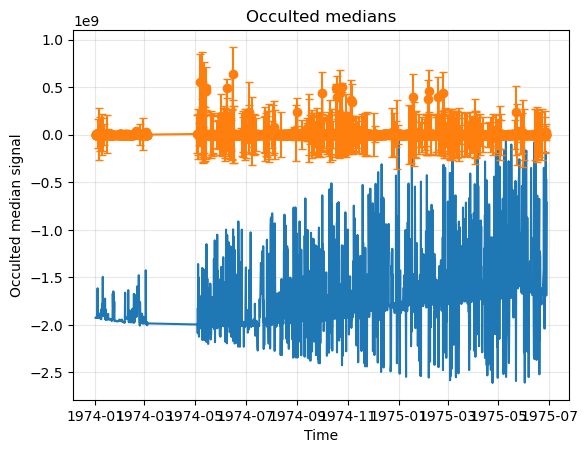

In [44]:
fbin = 2
z = np.array(stats[fbin]['occulted']['z'])
times = stats[fbin]['occulted']['time']
meds = stats[fbin]['occulted']['median']
stds = stats[fbin]['occulted']['std']
idx = range(len(meds))

fig, ax = plt.subplots()
ax.plot(times,z*1e6)
ax.errorbar(times, meds, yerr=stds, fmt='o-', capsize=3)
ax.set_xlabel('Time')
ax.set_ylabel('Occulted median signal')
ax.set_title(f'Occulted medians')
ax.grid(True, alpha=0.3)

In [35]:
z

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [29]:
stats = occultationStatisticsSigma(earthOccult,'JupiterVis',n=5)

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-05-23 20:22:31.483000
1974-05-23 20:38:54.456000
NaN detected in non-occulted period
0
1974-05-26 18:23:15.030000
1974-05-26 19:15:26.333000
Skipping empty occultation period: 1974-06-05 00:43:35.898000 to 1974-06-05 00:55:30.142000
NaN detected in occultation period
1
1974-08-07 20:49:01.440000
1974-08-08 00:00:29.446000
NaN detected in occultation period
2
1974-08-18 00:00:07.781000
1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-09-12 04:30:44.356000 to 1974-09-12 04:51:59.216000
Skipping empty occultation period: 1974-11-19 23:38:18.972000 to 1974-11-20 00:00:07.676000
Skipping empty occultation period: 1974-11-22 23:59:51.521000 to 1974-11-23 00:03:41.606000
Skipping empty occultation period: 1974-12-03 00:04:26.070000 to 1974-12-03 00:08:39.752000
NaN detected in occultation period
1
1974-12-16 00:32:27.024000
1974-12-16 02:22:16.301000
Skipping empty occultation period: 1975-04-08 23:41:48.421000 to 1975-04-09 01:42:5

NaN detected in non-occulted period
0
1974-05-23 20:22:31.483000
1974-05-23 20:38:54.456000
Skipping empty occultation period: 1974-06-05 00:43:35.898000 to 1974-06-05 00:55:30.142000
Skipping empty occultation period: 1974-08-07 20:49:01.440000 to 1974-08-08 00:00:29.446000
Skipping empty occultation period: 1974-08-18 00:00:07.781000 to 1974-08-18 00:03:04.399000
Skipping empty occultation period: 1974-08-20 01:08:02.313000 to 1974-08-20 01:59:12.352000
Skipping empty occultation period: 1974-09-12 04:30:44.356000 to 1974-09-12 04:51:59.216000
Skipping empty occultation period: 1974-12-16 00:32:27.024000 to 1974-12-16 02:22:16.301000
NaN detected in occultation period
1
1975-04-08 23:41:48.421000
1975-04-09 01:42:53.197000


In [42]:
%matplotlib qt
plotNormalizedOccultationHistograms(stats,use_std_weights=True,apply_filter=True,min_bin_percentage=0.1,fig_label='Jupiter')

In [33]:
%matplotlib qt
occulted_hist = histograms[1]['occulted']['hist']  # Skip the first bin
occulted_bins = histograms[1]['occulted']['bins']  # Skip the first bin edge
nonOcculted_hist = histograms[1]['nonOcculted']['hist']  # Skip the first bin
nonOcculted_bins = histograms[1]['nonOcculted']['bins']  # Skip the first bin edge

# Plot the remaining histogram data
plt.hist(
    occulted_bins[:-1], bins=occulted_bins, weights=occulted_hist, 
    alpha=0.6, label='Occulted', color='blue'
)

plt.hist(
    nonOcculted_bins[:-1], bins=nonOcculted_bins, weights=nonOcculted_hist, 
    alpha=0.6, label='Non-Occulted', color='orange'
)

# Add labels, legend, and display
plt.xlabel('rv1_coarse')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [49]:
%matplotlib qt
occultationHistogramPlotter(histograms)

NameError: name 'histograms' is not defined

In [45]:
orbitDelta

{2: -561, 1: -137, 9: 356, 8: 499, 7: 527, 6: 465, 5: -739, 4: -556, 3: -588}

In [46]:
numOfOrbits

{2: 2625,
 1: 2623,
 9: 2622,
 8: 2627,
 7: 2627,
 6: 2625,
 5: 2619,
 4: 2620,
 3: 2618}

In [47]:
values_first = np.array([-561, -137, 356, 499, 527, 465, -739, -556, -588])

values_second = np.array([2625, 2623, 2622, 2627, 2627, 2625, 2619, 2620, 2618])

keys = [2, 1, 9, 8, 7, 6, 5, 4, 3]



# Perform the division

result = values_first / np.sqrt(values_second)



# Associate results with their corresponding keys

result_dict = dict(zip(keys, result))



# Print the results

for key, value in result_dict.items():

    print(f"{key}: {value:.4f}")

2: -10.9496
1: -2.6750
9: 6.9524
8: 9.7358
7: 10.2821
6: 9.0759
5: -14.4403
4: -10.8624
3: -11.4919


In [13]:
earthOccult.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,marsAngle
time,,,,,,,,,,,,,,,
1974-01-01 14:00:00.472,8,1405.177612,-2324.264282,676.282288,-0.984300,-0.102829,-0.143458,19.990051,22.859650,1.558787e+06,678791.3750,0.000,0.0000,1092909793,-22.169077
1974-01-01 14:00:02.397,8,1407.012268,-2323.617737,674.645844,-0.984299,-0.102834,-0.143460,19.992851,22.825348,1.024165e+06,572116.1250,0.000,0.0000,1092909793,-22.149692
1974-01-01 14:00:04.322,8,1408.846924,-2322.971191,673.009399,-0.984298,-0.102838,-0.143462,19.995651,22.791046,2.062520e+06,780709.0625,935338.625,579085.3125,1092909793,-22.130406
1974-01-01 14:00:06.247,8,1410.681580,-2322.324646,671.372955,-0.984297,-0.102843,-0.143464,19.998451,22.756744,1.355128e+06,572116.1250,0.000,0.0000,1092909793,-22.111221
1974-01-01 14:00:08.172,8,1412.516235,-2321.678101,669.736511,-0.984297,-0.102848,-0.143466,20.001251,22.722443,1.793041e+06,637875.3125,0.000,0.0000,1092909793,-22.092136


In [12]:
earthOccult['earthAngle'] = angularSepEarth2(earthOccult)

In [45]:
earthOccult.head(800)

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,marsAngle
time,,,,,,,,,,,,,,,
1974-01-01 14:00:00.472,8,1405.177612,-2324.264282,676.282288,-0.984300,-0.102829,-0.143458,19.990051,22.859650,1.558787e+06,678791.3750,0.000,0.0000,1092909793,-22.169077
1974-01-01 14:00:02.397,8,1407.012268,-2323.617737,674.645844,-0.984299,-0.102834,-0.143460,19.992851,22.825348,1.024165e+06,572116.1250,0.000,0.0000,1092909793,-22.149692
1974-01-01 14:00:04.322,8,1408.846924,-2322.971191,673.009399,-0.984298,-0.102838,-0.143462,19.995651,22.791046,2.062520e+06,780709.0625,935338.625,579085.3125,1092909793,-22.130406
1974-01-01 14:00:06.247,8,1410.681580,-2322.324646,671.372955,-0.984297,-0.102843,-0.143464,19.998451,22.756744,1.355128e+06,572116.1250,0.000,0.0000,1092909793,-22.111221
1974-01-01 14:00:08.172,8,1412.516235,-2321.678101,669.736511,-0.984297,-0.102848,-0.143466,20.001251,22.722443,1.793041e+06,637875.3125,0.000,0.0000,1092909793,-22.092136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974-01-01 14:32:46.493,7,2471.804932,-835.937317,-1036.490295,-0.983519,-0.107487,-0.145386,22.641228,-12.847726,6.718571e+05,339305.2500,0.000,0.0000,1092909793,48.055167
1974-01-01 14:32:48.418,7,2471.911987,-833.880341,-1037.967743,-0.983518,-0.107491,-0.145388,22.643940,-12.880462,5.569423e+05,339305.2500,0.000,0.0000,1092909793,48.100811
1974-01-01 14:32:50.343,7,2472.019043,-831.823364,-1039.445190,-0.983517,-0.107496,-0.145389,22.646652,-12.913199,5.569423e+05,323591.3750,544263.375,369649.1875,1092909793,48.146463


In [14]:
earthOccult['isVis'] = isVisible(earthOccult,earthOccult['earthAngle'])

In [15]:
earthOccult[earthOccult['isVis']==False].head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,earthAngle,isVis
time,,,,,,,,,,,,,,,,
1974-01-01 14:24:40.763,3,2384.904388,-1331.490356,-640.779327,-0.983714,-0.106336,-0.144910,21.976913,-4.313641,1170001.0,1543415.0,0.0,0.0,1092909793,40.905107,False
1974-01-01 14:24:42.688,3,2385.509338,-1329.658936,-642.426453,-0.983713,-0.106340,-0.144912,21.979462,-4.348294,1267152.0,1594358.0,0.0,0.0,1092909793,40.888902,False
1974-01-01 14:24:44.613,3,2386.114288,-1327.827515,-644.073578,-0.983713,-0.106345,-0.144913,21.982010,-4.382947,1133257.0,1594358.0,0.0,0.0,1092909793,40.872745,False
1974-01-01 14:24:48.422,2,2387.316895,-1324.160370,-647.366028,-0.983711,-0.106354,-0.144917,21.987110,-4.452235,2353768.0,3184362.0,0.0,0.0,1092909793,40.840572,False
1974-01-01 14:24:50.347,2,2387.914551,-1322.324646,-649.011353,-0.983710,-0.106359,-0.144919,21.989662,-4.486871,2865539.0,3345892.0,0.0,0.0,1092909793,40.824557,False


In [19]:
orbitDelta,numOfOrbits = occulted(earthOccult)

C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\adamf\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
orbitDelta

{3: 151, 2: 87, 1: 241, 9: 568, 8: 302, 7: 49, 6: 267, 5: -418, 4: -31}

In [21]:
numOfOrbits

{3: 1809,
 2: 1813,
 1: 1819,
 9: 1816,
 8: 1820,
 7: 1823,
 6: 1821,
 5: 1802,
 4: 1809}

In [37]:
earthOccult.iloc[-1]

frequency_band         3.000000e+00
position_x            -1.283223e+03
position_y            -1.505364e+03
position_z             1.980284e+03
earth_unit_vector_x   -7.731489e-01
earth_unit_vector_y   -5.536783e-01
earth_unit_vector_z   -3.093235e-01
right_ascension        1.469120e+01
declination            5.160356e+01
rv1_coarse             8.030133e+05
rv2_coarse             1.126561e+06
rv1_fine               0.000000e+00
rv2_fine               0.000000e+00
rv_temp                1.092092e+09
earthAngle             1.153056e+02
Name: 1974-02-27 09:59:59.050000, dtype: float64

In [27]:
# J2000 SUN RA DEC DEC 12 1973
#RA 17h 20m 54s  Dec  -23° 08' 24"
midTime = Time(earthOccult.index[len(earthOccult)//2].to_pydatetime())
sunSource = get_sun(midTime).transform_to(FK4(equinox=Time('B1950')))

In [28]:
sunAngle = [sunSource.ra,sunSource.dec]

In [29]:
print(sunAngle)

[<Longitude 139.7378727 deg>, <Latitude 16.8162795 deg>]


In [30]:
earthOccult['sunAngle'] = raeAngFromSource(earthOccult,sunAngle)

In [31]:
earthOccult.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,sunAngle
time,,,,,,,,,,,,,,,
1974-01-01 14:00:00.472,8,1405.177612,-2324.264282,676.282288,-0.984300,-0.102829,-0.143458,19.990051,22.859650,1.558787e+06,678791.3750,0.000,0.0000,1092909793,144.149675
1974-01-01 14:00:02.397,8,1407.012268,-2323.617737,674.645844,-0.984299,-0.102834,-0.143460,19.992851,22.825348,1.024165e+06,572116.1250,0.000,0.0000,1092909793,144.199399
1974-01-01 14:00:04.322,8,1408.846924,-2322.971191,673.009399,-0.984298,-0.102838,-0.143462,19.995651,22.791046,2.062520e+06,780709.0625,935338.625,579085.3125,1092909793,144.249117
1974-01-01 14:00:06.247,8,1410.681580,-2322.324646,671.372955,-0.984297,-0.102843,-0.143464,19.998451,22.756744,1.355128e+06,572116.1250,0.000,0.0000,1092909793,144.298830
1974-01-01 14:00:08.172,8,1412.516235,-2321.678101,669.736511,-0.984297,-0.102848,-0.143466,20.001251,22.722443,1.793041e+06,637875.3125,0.000,0.0000,1092909793,144.348537


In [43]:
print(type(earthOccult))

<class 'pandas.core.frame.DataFrame'>


In [44]:
galactic_center = SkyCoord(ra="17h42m29.3s", dec="-28d55m00s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg))
centerAngle = [galactic_center.ra,galactic_center.dec]

In [45]:
earthOccult['centerAngle'] = raeAngFromSource(earthOccult,centerAngle)

In [46]:
earthOccult['earthVis'] = isVisible(earthOccult,earthOccult['earthAngle'])

In [47]:
earthOccult['sunVis'] = isVisible(earthOccult,earthOccult['sunAngle'])

In [48]:
earthOccultSubset = earthOccult[(earthOccult['earthVis'] == False) & (earthOccult['sunVis'] == False)]

In [49]:
#plt.scatter(earthOccultSubset.index,earthOccultSubset['earthAngle'],alpha=0.5)
plt.scatter(earthOccult.index,earthOccult['sunAngle'],alpha=0.5)

In [50]:
earthOccultSubset.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,earthAngle,sunAngle,centerAngle,earthVis,sunVis
time,,,,,,,,,,,,,,,,,,,


In [51]:
starttime = pd.to_datetime("1974-02-13 07:30")
endtime = pd.to_datetime("1974-02-13 12:00")
earthOccultSubset = earthOccult[(earthOccult.index>starttime)&(earthOccult.index<endtime)]

In [52]:
earthOccult.head(2600)

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,earthAngle,sunAngle,centerAngle,earthVis,sunVis
time,,,,,,,,,,,,,,,,,,,
1974-02-27 07:00:01.319,4,1273.153503,-2460.490479,430.072510,-0.790938,-0.532230,-0.301906,19.779827,17.762569,2336676.000,1.326813e+06,0.0,0.0,1092427448,93.114377,143.682136,-48.589215,True,True
1974-02-27 07:00:03.244,4,1274.861359,-2459.897217,428.290894,-0.790935,-0.532234,-0.301908,19.782358,17.725809,2336676.000,1.232202e+06,0.0,0.0,1092427448,93.091545,143.733900,-48.582648,True,True
1974-02-27 07:00:05.169,4,1276.569214,-2459.303955,426.509277,-0.790932,-0.532238,-0.301909,19.784889,17.689049,2596392.000,1.232202e+06,2309724.0,1193617.0,1092427448,93.068711,143.785663,-48.576121,True,True
1974-02-27 07:00:07.094,4,1278.277069,-2458.710693,424.727661,-0.790929,-0.532242,-0.301910,19.787420,17.652288,2596392.000,1.262970e+06,0.0,0.0,1092427448,93.045874,143.837427,-48.569636,True,True
1974-02-27 07:00:09.019,4,1279.984924,-2458.117432,422.946045,-0.790926,-0.532245,-0.301912,19.789951,17.615528,2420216.000,1.359143e+06,0.0,0.0,1092427448,93.023034,143.889191,-48.563190,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974-02-27 08:53:02.546,7,-1368.882629,2422.352844,-326.255981,-0.779847,-0.545747,-0.306592,7.364527,-7.332388,344152.250,3.857367e+05,0.0,0.0,1092238704,-86.422449,-33.335173,131.736451,True,False
1974-02-27 08:53:04.471,7,-1370.539948,2421.664581,-324.458801,-0.779844,-0.545751,-0.306594,7.367028,-7.296514,380905.125,3.201998e+05,0.0,0.0,1092238704,-86.445057,-33.283359,131.740650,True,False
1974-02-27 08:53:08.280,6,-1373.834198,2420.251495,-320.859222,-0.779837,-0.545759,-0.306596,7.372019,-7.224638,667000.000,4.192531e+05,0.0,0.0,1092238704,-86.490287,-33.179724,131.748925,True,False


In [72]:
frequencies = np.sort(earthOccult['frequency_band'].unique())

In [74]:
%matplotlib qt
fig, axes = plt.subplots(3, 3, figsize=(10, 4.1 * len(frequencies)), sharex=True)
for ax, freq in zip(axes.flatten(), frequencies):
    freq_df = earthOccult[earthOccult['frequency_band'] == freq]
    
    
    ax.scatter(freq_df.index, freq_df['rv1_coarse'], marker='o', linestyle='-')
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    #for start, stop in zip(freq_df.index[:-1], freq_df.index[1:]):
        #if freq_df.loc[start, 'earthVis']:
            #ax.axvspan(start, stop, color='blue', alpha=0.01)

    # Highlight regions where sun is visible (sunVis is True)
    for start, stop in zip(freq_df.index[:-1], freq_df.index[1:]):
        if freq_df.loc[start, 'isVis']:
            ax.axvspan(start, stop, color='orange', alpha=0.01)
    ax.set_xlabel('Time since start of period (s)')
    
    #ax2 = ax.twinx()
    #ax2.plot(freq_df.index, freq_df['rv_temp'], color='green', linestyle='--')
    #ax2.scatter(freq_df.index,freq_df['centerAngle'],color='green')
    #ax2.set_ylabel('Angle Galactic Center', color='green')
    
    # Optionally set the y-axis limits for better visualization
    #ax2.tick_params(axis='y', labelcolor='green')
    
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    #ax.set_ylabel('rv1_coarse')
    ax.grid(True)
    #ax.set_yscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

In [59]:
%matplotlib qt
fig, axes = plt.subplots(3, 3, figsize=(9, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes.flatten(), frequencies):
    freq_df = earthOccult[earthOccult['frequency_band'] == freq]
    
    
    ax.scatter(freq_df['centerAngle'], freq_df['rv1_coarse'], marker='o', linestyle='-')
    
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.set_xlabel('Center Angle')
    ax.grid(True)
    #ax.set_yscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

In [103]:
plt.scatter(earthOccult.index,earthOccult['earthAngle'])
plt.scatter(earthOccult.index,earthOccult['angularSepEarth2'],label='good one')
plt.legend()

In [102]:
plt.plot(earthOccult['earthAngle']-earthOccult['angularSepEarth2'])

In [88]:
datetime = pd.to_datetime("1973-12-12 15:20")
earthOccultspecific = earthOccult[earthOccult.index>datetime]

In [104]:
earthOccultspecific.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,earthAngle,earthVis,angularSepEarth2
time,,,,,,,,,,,,,,,,,
1973-12-12 15:20:00.640,5,-2238.256287,1687.233398,139.754704,0.448098,-0.836559,-0.315240,8.935359,2.511674,1192851.0,6107888.0,0.0,0.0,1092322590,28.633733,False,-28.633733
1973-12-12 15:20:02.565,5,-2239.286285,1685.678467,141.473082,0.448103,-0.836557,-0.315239,8.937879,2.546717,1248511.0,5597584.0,0.0,0.0,1092322590,28.644947,False,-28.644947
1973-12-12 15:20:04.490,5,-2240.316284,1684.123535,143.191460,0.448108,-0.836555,-0.315237,8.940399,2.581759,1129453.0,6645438.0,1253769.0,4934200.0,1092322590,28.656240,False,-28.656240
1973-12-12 15:20:06.415,5,-2241.346283,1682.568604,144.909838,0.448114,-0.836553,-0.315236,8.942919,2.616802,1171331.0,6645438.0,0.0,0.0,1092322590,28.667613,False,-28.667613
1973-12-12 15:20:08.340,5,-2242.376282,1681.013672,146.628216,0.448119,-0.836550,-0.315234,8.945439,2.651845,1279266.0,5597584.0,0.0,0.0,1092322590,28.679066,False,-28.679066


In [27]:
plt.plot(earthOccult.index,earthOccult['rv_temp'])
plt.xlabel('Time')
plt.ylabel('RV Temp')

Text(0, 0.5, 'RV Temp')

In [5]:
import struct

# Example 4-byte integer
int_value = 1092322590  # This is 0x3F800000 in hex, which corresponds to 1.0 in float

byte_array = int_value.to_bytes(4, byteorder='big')
reversed_bytes = byte_array[::-1]

reversed_value = int.from_bytes(int_value.to_bytes(4, byteorder='big'), byteorder='little')
floatForwards = struct.unpack('f', byte_array)[0]
floatBackwards = struct.unpack('f', reversed_bytes)[0]
print("Integer",int_value)
print("Reversed integer:", reversed_value)
print('Float big:', floatForwards)
print('Float Back:', floatBackwards)

Integer 1092322590
Reversed integer: 512039745
Float big: 1.4093194699535912e-20
Float Back: 9.719999313354492


In [15]:
int_value = 512039745

float_value = struct.unpack('f', struct.pack('I', int_value))[0]

print(float_value)

1.4093194699535912e-20


In [21]:
earthOccult['TempFloat'] = [int.from_bytes(int_val.to_bytes(4, byteorder='little'), byteorder='big') for int_val in earthOccult['rv_temp']]

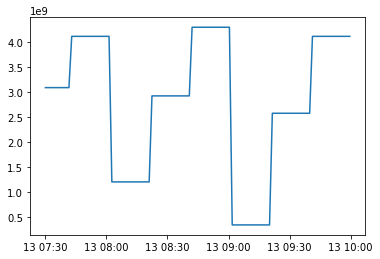

In [22]:
plt.plot(earthOccult['TempFloat'])